In [2]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from roboflow import Roboflow
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np
import glob

ModuleNotFoundError: No module named 'roboflow'

In [2]:
rf = Roboflow(api_key="0Z4VoCgLChWeuoeTexjI")
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:04<00:00, 4426.28it/s]


In [3]:
#  -----  CODE IN THIS CELL WRITTEN BY SAYED GAMALL IN HIS IMPLEMENTATION OF THIS PROJECT  -----

# Path to the YAML file
file_path = f'{dataset.location}/data.yaml'

# Step 1: Read the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Step 2: Update paths for train, val, and test
base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

# Step 3: Save the updated YAML data back to the file
with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")
print(f"{base_path}")

Paths updated successfully!
/content/Fire-Smoke-Detection-Yolov11-2


In [4]:
from pprint import pprint

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

pprint(data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/content/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/content/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/content/Fire-Smoke-Detection-Yolov11-2/valid/images'}


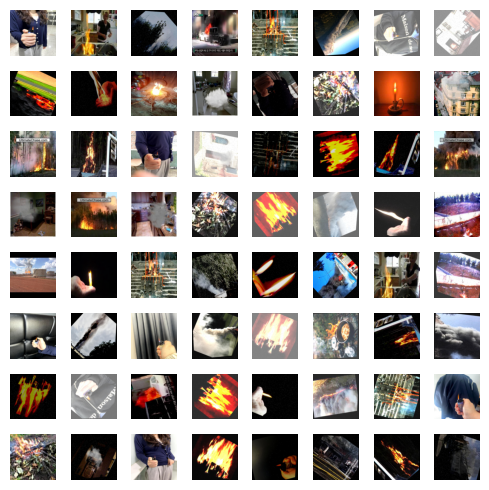

(640, 640, 3)


In [5]:
# Define dataset image path
image_folder = f"{dataset.location}/train/images"

# Get the first few image filenames 8*8=64 in our case here
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))][:64]

# Set up plot grid (8*8)
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Loop through and plot images
for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        img_path = os.path.join(image_folder, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.show()
print(img.shape)

# Class Distribution

In [6]:

label_folder_train = r"/content/Fire-Smoke-Detection-Yolov11-2/train/labels"
label_folder_val = r"/content/Fire-Smoke-Detection-Yolov11-2/valid/labels"
label_folder_test = r"/content/Fire-Smoke-Detection-Yolov11-2/test/labels"


def get_class_distribution(label_folder):
    class_counts = Counter()  # Initialize inside function
    bounded_boxes = []

    annotation_files = glob.glob(os.path.join(label_folder, '*.txt'))

    for filename in annotation_files:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                segments = line.strip().split()
                if len(segments) == 5:
                    class_id = int(segments[0])
                    x_center, y_center, width, height = map(float, segments[1:])
                    class_counts[class_id] += 1
                    bounded_boxes.append([x_center, y_center, width, height])
                else:
                    print(len(segments), "Skipping line with unexpected format:", segments)

    return class_counts, bounded_boxes

class_counts, bounded_boxes = get_class_distribution(label_folder_train)

box_df = pd.DataFrame(bounded_boxes, columns=['x_center', 'y_center', 'width', 'height'])

13 Skipping line with unexpected format: ['1', '0.9861458781250001', '0.5285430515625', '0.573206884375', '0.4851945171875', '0.54123101875', '0.8764357296874999', '0.9560986343750001', '0.9199867218750001', '0.98507051875', '0.5655007484375', '0.9861458781250001', '0.5285430515625']
19 Skipping line with unexpected format: ['1', '0.3473343875', '0', '0', '0.2664940359375', '0', '0.48074210156249997', '0.3488577484375', '0.97194078125', '0.5291705140625', '0.959332084375', '0.963524246875', '0.6260720234375', '0.9820179375', '0.273191378125', '0.7879927234374999', '0', '0.3473343875', '0']
11 Skipping line with unexpected format: ['1', '0.7', '0.1203125', '0.1609375', '0.1203125', '0.1609375', '0.7015625', '0.7', '0.7015625', '0.7', '0.1203125']
11 Skipping line with unexpected format: ['1', '0.7046875', '0.3890625', '0.1296875', '0.3890625', '0.1296875', '0.95625', '0.7046875', '0.95625', '0.7046875', '0.3890625']
19 Skipping line with unexpected format: ['1', '0.4290139203125', '0', 

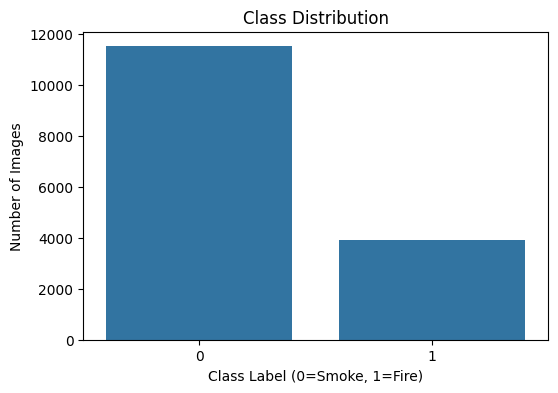

In [7]:
if class_counts:
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution')
    plt.xlabel('Class Label (0=Smoke, 1=Fire)')
    plt.ylabel('Number of Images')
    plt.xticks([0, 1])
    plt.show()
else:
    print("No class distribution data available.")

Text(0, 0.5, 'Frequency')

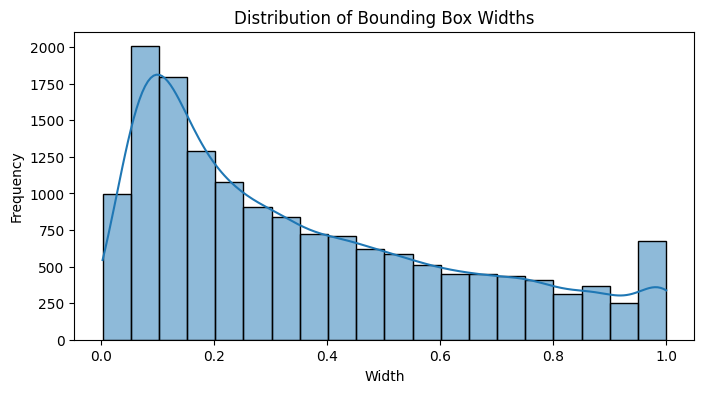

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(box_df['width'], bins=20, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

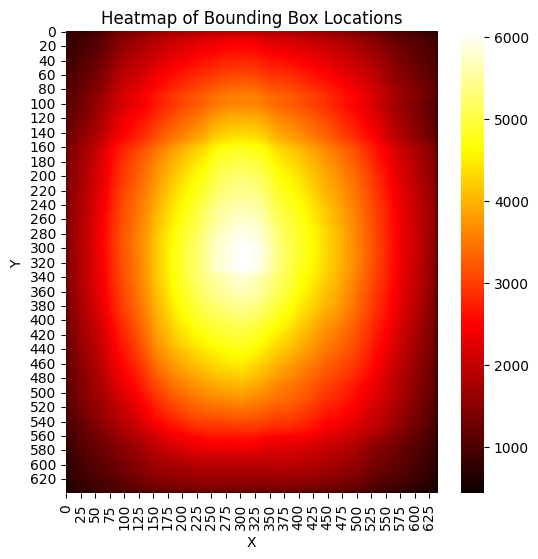

In [9]:
heatmap = np.zeros((640, 640))

for _, row in box_df.iterrows():
  x,y,w,h = row['x_center'], row['y_center'], row['width'], row['height']
  x1, y1 = int((x - w/2) * 640), int((y - h/2) * 640)
  x2, y2 = int((x + w/2) * 640), int((y + h/2) * 640)
  heatmap[y1:y2, x1:x2] += 1

plt.figure(figsize=(6,6))
sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title('Heatmap of Bounding Box Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Model


Define Convolutional Block, This headder is used for both darknet and yolo

In [11]:
class ConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvUnit, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))


ResidualUnit is used a few times in darknet

In [12]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels):
        super(ResidualUnit, self).__init__()
        self.conv1 = ConvUnit(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvUnit(in_channels//2, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))  # Skip connection


In [13]:
class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()

        self.conv1 = ConvUnit(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvUnit(32, 64, kernel_size=3, stride=2, padding=1)
        self.res1 = ResidualUnit(64)

        self.conv3 = ConvUnit(64, 128, kernel_size=3, stride=2, padding=1)
        self.res2 = nn.Sequential(ResidualUnit(128), ResidualUnit(128))

        self.conv4 = ConvUnit(128, 256, kernel_size=3, stride=2, padding=1)
        self.res3 = nn.Sequential(*[ResidualUnit(256) for _ in range(8)])

        self.conv5 = ConvUnit(256, 512, kernel_size=3, stride=2, padding=1)
        self.res4 = nn.Sequential(*[ResidualUnit(512) for _ in range(8)])

        self.conv6 = ConvUnit(512, 1024, kernel_size=3, stride=2, padding=1)
        self.res5 = nn.Sequential(*[ResidualUnit(1024) for _ in range(4)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.conv3(x)
        x = self.res2(x)
        x = self.conv4(x)
        x = self.res3(x)
        x = self.conv5(x)
        x = self.res4(x)
        x = self.conv6(x)
        x = self.res5(x)
        return x  # Feature map used in YOLO detection head


Yolo Head

In [14]:
class YOLOHead(nn.Module):
    def __init__(self, num_classes):
        super(YOLOHead, self).__init__()
        self.conv1 = ConvUnit(1024, 512, 1, 1, 0)
        self.conv2 = ConvUnit(512, 1024, 3, 1, 1)
        self.conv3 = nn.Conv2d(1024, (num_classes + 5) * 3, kernel_size=1)  # 3 anchors per grid cell

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x).reshape(x.shape[0], 3, -1, x.shape[2], x.shape[3])  # Reshape for YOLO anchors


Combine Yolo and Darknet Head

In [15]:
class YOLOv3(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv3, self).__init__()
        self.backbone = Darknet53()
        self.yolo_head = YOLOHead(num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return self.yolo_head(x)


# Loss Function

In [17]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss()  # For bounding box regression
        self.bce_loss = nn.BCEWithLogitsLoss()  # For objectness & class predictions

    def forward(self, predictions, targets):
        """
        Args:
            predictions: (batch_size, num_anchors, 7, grid_size, grid_size)
                        [x, y, w, h, obj_score, class_scores]
            targets: Ground truth labels in the same format.
        """

        # Extract components
        pred_boxes = predictions[:, :, :4]  # x, y, w, h
        pred_obj = predictions[:, :, 4]  # Object confidence score
        pred_class = predictions[:, :, 5:]  # Class probabilities

        target_boxes = targets[:, :, :4]  # Ground truth bbox
        target_obj = targets[:, :, 4]  # Ground truth objectness score
        target_class = targets[:, :, 5:]  # Ground truth class

        # Compute Bounding Box Loss (MSE)
        bbox_loss = self.mse_loss(pred_boxes, target_boxes)

        # Compute Objectness Loss (BCE)
        obj_loss = self.bce_loss(pred_obj, target_obj)

        # Compute Classification Loss (BCE)
        class_loss = self.bce_loss(pred_class, target_class)

        # Total Loss
        total_loss = (self.lambda_coord * bbox_loss) + obj_loss + (class_loss)

        return total_loss


In [ ]:
# Example input (batch_size=1, num_anchors=3, 7 params, grid_size=13x13)
preds = torch.rand((1, 3, 7, 13, 13))  # Fake predictions
targets = torch.rand((1, 3, 7, 13, 13))  # Fake ground truth

loss = yolo_loss(preds, targets)
print("Sample Loss:", loss.item())


# Train

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv3(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = YOLOLoss(num_classes=2)  # You need to define this


In [ ]:
num_classes = 2  # Fire and Smoke
yolo_loss = YOLOLoss(num_classes)

# Training loop
def train(model, dataloader, optimizer, loss_function, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)

            preds = model(images)  # Forward pass
            loss = loss_function(preds, targets)  # Compute YOLO loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Run training
train(model, dataloader, optimizer, yolo_loss, epochs=20)



# TEST

In [ ]:
def detect_fire(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (416, 416))
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

    model.eval()
    with torch.no_grad():
        preds = model(image.to(device))

    # Apply Non-Maximum Suppression (NMS) here (you need to define it)
    preds = non_max_suppression(preds, conf_threshold=0.5, iou_threshold=0.4)

    return preds

fire_detections = detect_fire(model, "fire_image.jpg")
print(fire_detections)
